In [10]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [11]:
# High number of epochs, change for faster results
import numpy as np

# only a batch size of 1 works with hinge loss right now, with bce loss a larger batch size works, but in general a smaller batch size leads to better convergence, but still could theoretically introduce more noise
BATCH_SIZE = 1
EPOCHS = 10
SEED = 2


In [12]:
# this sample data is found in folder data
def read_raw_data(filename):
    raw_data = []
    with open(filename) as f:
        for line in f:
            raw_data.append((line[:-2], line[-2]))
    return raw_data
raw_train_data = read_raw_data('data/bin_class_86_train_data.txt')
raw_dev_data = read_raw_data('data/bin_class_86_dev_data_1.txt')
#raw_test_data = read_raw_data('data/bin_class_23_test_data.txt')

In [13]:
raw_train_data[-1]

('dog chases after cat ', '2')

In [14]:
grammar_classes = {
    'nouns': ["dog", "cat", "mouse", "fox", "chicken", "grain", "cheese", "bone", "fish", "whale", "seal", "krill", "water", "land"],
    'transitive_verbs': ["chases", "flees", "bites", "eats"],
    'intransitive_verbs': ["barks", "meows", "squeaks", "clucks", "chases", "runs", "swims"],
     'prepositions': ["at", "after", "in", "on"]
}

In [15]:
from nltk import word_tokenize
def create_training_data(raw_data):
    labels, sentences = [], []
    for tupl in raw_data:
        labels.append([1,0])
        labels.append([1,0])
        labels.append([1,0])
        labels.append([1,0])
        labels.append([1,0])
        labels.append([1,0])
        labels.append([1,0])
        sentences.append(tupl[0])
        sentences.append(tupl[0])
        sentences.append(tupl[0])
        sentences.append(tupl[0])
        sentences.append(tupl[0])
        sentences.append(tupl[0])
        sentences.append(tupl[0])
        replaced_token = word_tokenize(tupl[0])[int(tupl[1])]
        for key, value in grammar_classes.items():
            if replaced_token in value:
                for word in value:
                    if word != replaced_token:
                        new_list = word_tokenize(tupl[0])
                        new_list[word_tokenize(tupl[0]).index(replaced_token)] = word
                        new_sen = ' '.join(new_list)
                        labels.append([0,1])
                        sentences.append(new_sen)
    return labels, sentences
training_labels, training_data = create_training_data(raw_train_data)
dev_labels, dev_data = create_training_data(raw_dev_data)
#test_labels, test_data = create_training_data(raw_test_data)

In [17]:
len(dev_labels)

358

In [7]:
from discopy import Functor, Ty, Word, Id, Cup, Diagram

s, n = Ty('s'), Ty('n')
tv = n.r @ s @ n.l
iv = n.r @ s
p = s.r @ n.r.r @ n.r @ s @ n.l

# grammars
grammars = [Cup(n, n.r) @ Id(s),
            Cup(n, n.r) @ Id(s) @ Cup(n.l, n),
            (Id(n) @ Id(n.r) @ Cup(s, s.r) @ Id(n.r.r) @ Id(n.r) >> Id(n) @ Cup(n.r, n.r.r) @ Id(n.r) >> Cup(n, n.r)) @ Id(s) @ Cup(n.l, n)]

class WordBox(Word):
    """ Word with Ty((name, cod)) as domain. """
    def __init__(self, name, cod):
        super().__init__(name, cod, dom=Ty())

def parse(dataset):
    diagram_list = []
    for tup in dataset:
        sen = tup
        tokenized_sen = word_tokenize(sen)
        lenght = len(tokenized_sen)
        if lenght == 2:
            subj_box = WordBox(tokenized_sen[0], n)
            verb_box = WordBox(tokenized_sen[1], iv)
            diagram = subj_box @ verb_box >> grammars[0]
        elif lenght == 3:
            subj_box = WordBox(tokenized_sen[0], n)
            verb_box = WordBox(tokenized_sen[1], tv)
            dobj_box = WordBox(tokenized_sen[2], n)
            diagram = subj_box @ verb_box @ dobj_box >> grammars[1]
        else:
            subj_box = WordBox(tokenized_sen[0], n)
            verb_box = WordBox(tokenized_sen[1], iv)
            prep_box = WordBox(tokenized_sen[2], p)
            idobj_box = WordBox(tokenized_sen[3], n)
            diagram = subj_box @ verb_box @ prep_box @ idobj_box >> grammars[2]
        diagram_list.append(diagram)
    return diagram_list

In [8]:
uncuped_train_diagrams = parse(training_data)
uncuped_dev_diagrams = parse(dev_data)

In [9]:
len(uncuped_dev_diagrams)

229

In [11]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in uncuped_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in uncuped_dev_diagrams]

In [27]:
# in this ansatz block, alot of parameters can be changed
from lambeq import AtomicType, IQPAnsatz, Sim14Ansatz, Sim15Ansatz, StronglyEntanglingAnsatz
qubit_map = {t: 1 for t in AtomicType}
N = AtomicType.NOUN
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITIONAL_PHRASE
ansatz = StronglyEntanglingAnsatz(ob_map={N: 1, S: 1, P:1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]

TypeError: Can't instantiate abstract class BaseAnsatz with abstract methods __call__, __init__

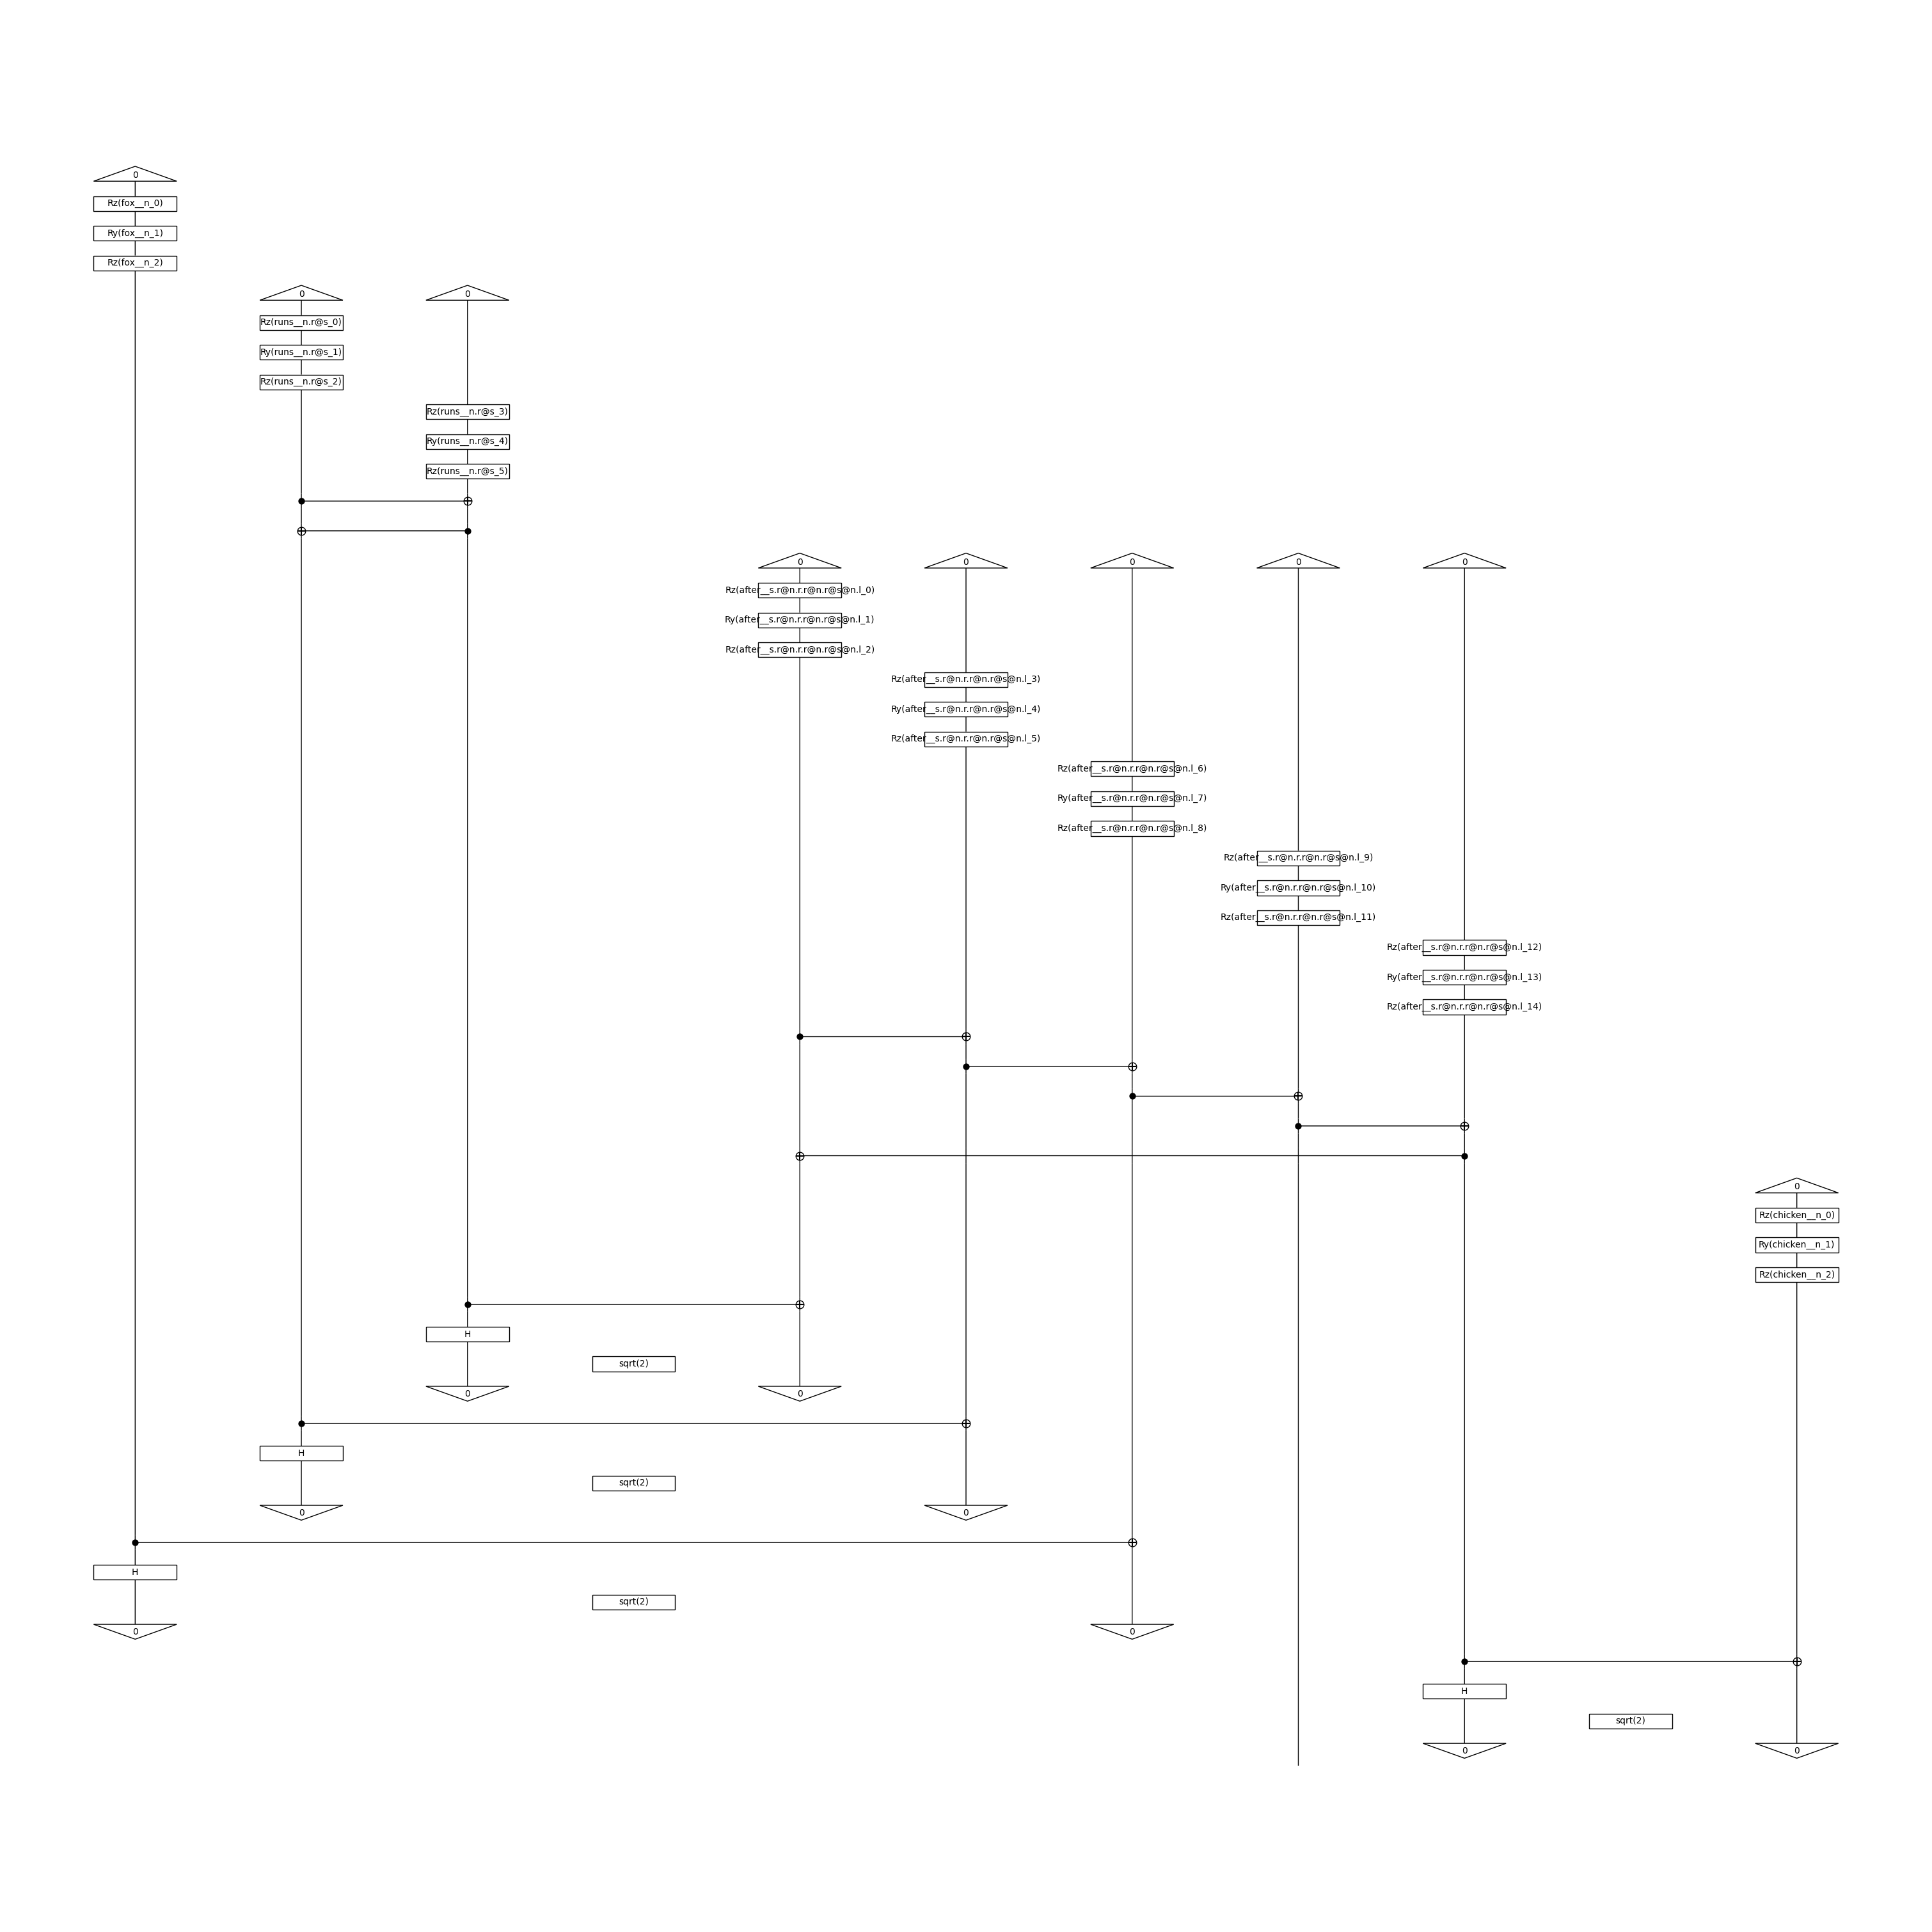

In [26]:
train_circuits[0].draw(figsize=(30,30))

In [12]:
from lambeq import NumpyModel

all_circuits = train_circuits + dev_circuits
model = NumpyModel.from_diagrams(all_circuits)

In [13]:
# another import from sklearn, may contain large files
from sklearn.metrics import hinge_loss as hinge_sk

# different loss functions, hinge loss outperforms binary cross entropy loss
def hinge_loss(y_hat, y):
    return hinge_sk(y[0], y_hat[0])

def bce_loss(y_hat, y):
    return -np.sum(y * np.log(y_hat)) / len(y)

def acc(y_hat, y):
    return np.sum(np.round(y_hat) == y) / len(y) / 2

In [14]:
from lambeq import QuantumTrainer, SPSAOptimizer

# here you can play around with hyperparameters
trainer = QuantumTrainer(
    model,
    loss_function=hinge_loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [15]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            training_labels,
            batch_size=BATCH_SIZE,
            shuffle=True)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

In [16]:
trainer.fit(train_dataset, val_dataset, logging_step=1)

Epoch 1:   train/loss: 0.9806   valid/loss: 1.0854   train/acc: 0.5386   valid/acc: 0.5240
Epoch 2:   train/loss: 0.9633   valid/loss: 0.5562   train/acc: 0.5483   valid/acc: 0.5066
Epoch 3:   train/loss: 0.9442   valid/loss: 0.6856   train/acc: 0.5646   valid/acc: 0.5415
Epoch 4:   train/loss: 0.9339   valid/loss: 0.5624   train/acc: 0.6055   valid/acc: 0.5240
Epoch 5:   train/loss: 0.9266   valid/loss: 0.7862   train/acc: 0.5743   valid/acc: 0.5852
Epoch 6:   train/loss: 0.8928   valid/loss: 0.8208   train/acc: 0.6493   valid/acc: 0.5284
Epoch 7:   train/loss: 0.8924   valid/loss: 0.6902   train/acc: 0.6620   valid/acc: 0.6288
Epoch 8:   train/loss: 0.8910   valid/loss: 0.7862   train/acc: 0.6560   valid/acc: 0.6725
Epoch 9:   train/loss: 0.8990   valid/loss: 0.5903   train/acc: 0.6204   valid/acc: 0.5983
Epoch 10:  train/loss: 0.8910   valid/loss: 0.9625   train/acc: 0.6456   valid/acc: 0.6070

Training completed!


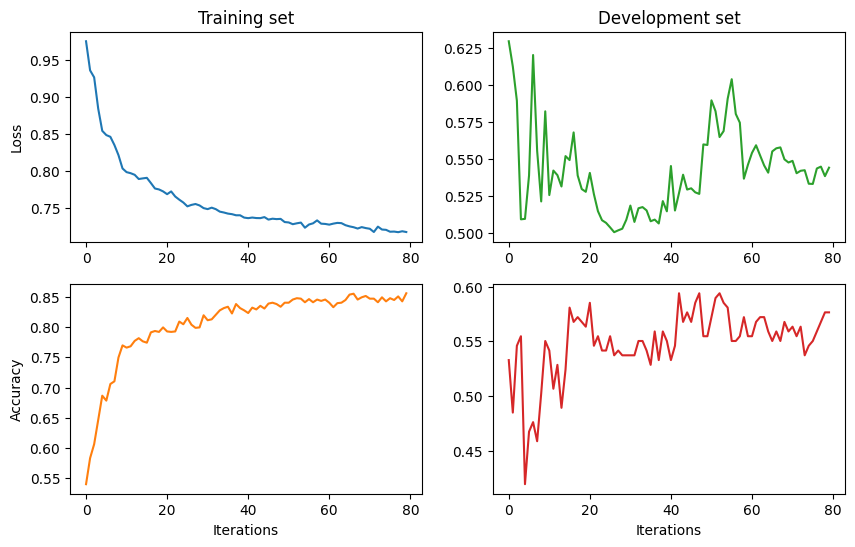

In [21]:
# plotting the results
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=False, figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))
fig.savefig('1.png')

In [52]:
def recall():
    TP = 0
    FN = 0
    for index, sen in enumerate(dev_circuits):
        if dev_labels[index] == [1, 0]:
            if list(np.round(model.forward([sen]))[0]) == [1, 0]: # Change later
                TP += 1
            elif list(np.round(model.forward([sen]))[0]) == [0, 1]: # Change later
                FN += 1

    return TP / (TP+FN)

def precision():
    TP = 0
    FP = 0
    for index, sen in enumerate(dev_circuits):
        if list(np.round(model.forward([sen]))[0]) == [1, 0]: # Change later
            if dev_labels[index] == [1, 0]:
                TP += 1
            elif dev_labels[index] == [0, 1]: # Change later
                FP += 1

    return TP / (TP+FP)

def F1(re, pr):
    return 2 * ((pr * re) / (pr + re))

0.5029940119760479

In [53]:
print(F1(re = recall(), pr = precision()))

0.6511627906976745